In [1]:
from twitterscraper import query_tweets
import datetime as dt 
import pandas as pd 
import cld3
import re
from collections import Counter
from wordcloud import WordCloud

#Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

INFO: {'User-Agent': 'Mozilla/5.0 (compatible, MSIE 11, Windows NT 6.3; Trident/7.0; rv:11.0) like Gecko'}


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
def fetch_tweets(query, start_date, end_date, limit = 10000, language = "English"):
    """
    start_date: date in form year,month,day
    """

    tweets = query_tweets(query, begindate = start_date, enddate = end_date, limit = limit, lang = language)
    df = pd.DataFrame(t.__dict__ for t in tweets)
    return df

In [32]:
start_date2 = dt.date(2020,2,1)
end_date2 = dt.date(2020,2,28)

start_date3 = dt.date(2020,3,1)
end_date3 = dt.date(2020,3,31)

start_date4 = dt.date(2020,4,1)
end_date4 = dt.date(2020,5,1)

limit = 25000
query = "coronavirus OR covid OR covid19 OR covid-19 OR corona virus OR #COVID19, OR #CoronavirusOutbreak" 

In [ ]:
tweets2 = fetch_tweets(query, start_date2, end_date2, limit = limit, language = 'english')

In [24]:
tweets2.shape

(13935, 21)

In [21]:
tweets2.to_csv (r'./data/tweets2.csv', index = False, header=True)

In [ ]:
tweets3 = fetch_tweets(query, start_date3, end_date3, limit = limit, language = 'english')

In [31]:
tweets3.shape

(13767, 21)

In [25]:
tweets3.to_csv (r'./data/tweets3.csv', index = False, header=True)

In [ ]:
tweets4 = fetch_tweets(query, start_date4, end_date4, limit = limit, language = 'english')

In [35]:
tweets4.to_csv (r'./data/tweets4.csv', index = False, header=True)

In [34]:
tweets4.shape

(13552, 21)

In [49]:
tweets = pd.concat([tweets2, tweets3, tweets4])
tweets.to_csv (r'./data/tweets.csv', index = False, header=True)

In [53]:
tweets.head(10)

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,geziel_goes,Dr. Geziel Goes🇧🇷🇵🇹,4867434249,1233180006743969792,/geziel_goes/status/1233180006743969792,2020-02-27 23:59:59,1582847999,Se o Coronavirus esta derrubando a bolsa no Br...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,0,0,0,False,False,,[]
1,Covid_19Time,COVID-19,1146021318082609152,1233180006655909888,/Covid_19Time/status/1233180006655909888,2020-02-27 23:59:59,1582847999,#Coronavirus #COVID19 \n\nIt’s going global @...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[https://twitter.com/Covid_19Time/status/12270...,...,True,[https://pbs.twimg.com/media/ER0irN5U0AADXHK.jpg],,26,8,2,True,False,,[]
2,29Toninho,Toninho,585940381,1233180004030152704,/29Toninho/status/1233180004030152704,2020-02-27 23:59:58,1582847998,Bien por esa acción. Es difícil navegar por el...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,0,0,0,False,True,1233054192756875264,"[{'screen_name': 'Anaro74', 'user_id': '104697..."
3,BrendynMorgan,b,263311303,1233180001496969222,/BrendynMorgan/status/1233180001496969222,2020-02-27 23:59:58,1582847998,This damn Corona virus knocked my stocks all t...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,1,0,0,False,False,,[]
4,BlindedSteer,Dusty Arth,460892027,1233179999605145600,/BlindedSteer/status/1233179999605145600,2020-02-27 23:59:57,1582847997,"@billburr So how many people are you secretly,...","<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,0,0,0,False,False,,[]
5,chanonthemove,Chan,918945874318835712,1233179999303110656,/chanonthemove/status/1233179999303110656,2020-02-27 23:59:57,1582847997,What a smart thinking! While other countries s...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,0,0,0,False,True,1233134824761643008,"[{'screen_name': 'BreakfastNews', 'user_id': '..."
6,realinformative,Informative Info ⭐⭐⭐,991438909841199104,1233179996900020229,/realinformative/status/1233179996900020229,2020-02-27 23:59:57,1582847997,"Live!! Pope Sick With Corona Virus, 8 Chan Fou...","<p class=""TweetTextSize js-tweet-text tweet-te...",[https://www.youtube.com/watch?v=o4y8_Gn98Ko],...,False,[],,1,0,0,False,False,,[]
7,Giovanna_V19,Vieira💻,4623487643,1233179996782518272,/Giovanna_V19/status/1233179996782518272,2020-02-27 23:59:57,1582847997,Meu irmão chorando feito doido por medo de mor...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,2,0,0,False,False,,[]
8,_RebekaC,vá lavar as mãos ♒,72704465,1233179993091563526,/_RebekaC/status/1233179993091563526,2020-02-27 23:59:56,1582847996,O corona virus pega o médico primeiro,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,0,0,1,True,True,1233179510117453824,"[{'screen_name': 'babiesticx', 'user_id': '116..."
9,VirusWatchAU,VirusWatchAU,1221228266263957509,1233179992592281601,/VirusWatchAU/status/1233179992592281601,2020-02-27 23:59:56,1582847996,PM says #coronavirus is 10x more severe than f...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,0,1,0,False,False,,[]


In [25]:
#Extract language of each tweet 
tweets['text'] = tweets['text'].apply(lambda x:str(x)) #remove floats

tweets['language'] = tweets['text'].apply(cld3.get_language).map(lambda x: x[0]) #Get the language of each tweet

In [28]:
tweets[['text', 'language']]

,text,language
0,Se o Coronavirus esta derrubando a bolsa no Br...,pt
1,#Coronavirus #COVID19 \n\nIt’s going global @...,no
2,Bien por esa acción. Es difícil navegar por el...,es
3,This damn Corona virus knocked my stocks all t...,mg
4,"@billburr So how many people are you secretly,...",en
...,...,...
41249,"There it is folks, 18 months of lockdown minim...",en
41250,Do us a favor @realDonaldTrump just STFU when ...,en
41251,#ThankYOUgina !!!\nWhat an amazing woman! Amer...,en
41252,@GovSisolak The only thing you would be gratef...,en


## Obtain English tweets of interest

In [29]:
english_tweets = tweets[tweets['language']=='en']
english_tweets[['text', 'language']]

,text,language
4,"@billburr So how many people are you secretly,...",en
5,What a smart thinking! While other countries s...,en
6,"Live!! Pope Sick With Corona Virus, 8 Chan Fou...",en
9,PM says #coronavirus is 10x more severe than f...,en
11,I'm obviously not a seasoned economist but my ...,en
...,...,...
41248,I’ll only ever hear corona virus in Cardi B’s ...,en
41249,"There it is folks, 18 months of lockdown minim...",en
41250,Do us a favor @realDonaldTrump just STFU when ...,en
41251,#ThankYOUgina !!!\nWhat an amazing woman! Amer...,en


In [30]:
english_tweets.shape

(20246, 22)

## Preprocess tweets

In [31]:
stemmer = PorterStemmer()

stop = stopwords.words('english')

In [39]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'pic\S*\s?', '', text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    text = ' '.join([word for word in text.split() if word not in (stop)])
    words=re.split("\\s+",text)
    stemmed_words=[stemmer.stem(word=word) for word in words]
    
    return ' '.join(stemmed_words)

In [40]:
english_tweets['prep_text'] = english_tweets['text'].apply(preprocess)

In [49]:
english_tweets['prep_text']

4        billburr mani peopl secretli deep kinda sorta ...
5        smart think countri itali switzerland austria ...
6        live pope sick corona viru chan founder run so...
9        pm say coronaviru x sever flu viru time sever ...
11       obvious season economist instinct blame stock ...
                               ...                        
41248                   ever hear corona viru cardi b voic
41249    folk month lockdown minimum forc vaccin newwor...
41250    us favor realdonaldtrump stfu come corona viru...
41251    thankyougina amaz woman america winner covid c...
41252    govsisolak thing would grate lazi fat fuck som...
Name: prep_text, Length: 20246, dtype: object

In [50]:
word_to_list = [word for line in english_tweets['prep_text'] for word in line.split()]
word_to_list[:20]

['billburr',
 'mani',
 'peopl',
 'secretli',
 'deep',
 'kinda',
 'sorta',
 'hope',
 'corona',
 'viru',
 'take',
 'billi',
 'billion',
 'peopl',
 'shhh',
 'bud',
 'tell',
 'smart',
 'think',
 'countri']

## Plotting Word Occurrence

In [51]:
occurence = Counter(word_to_list).most_common(50)
occurence_df = pd.DataFrame(occurence, columns=['stemmed_word', 'frequency'])

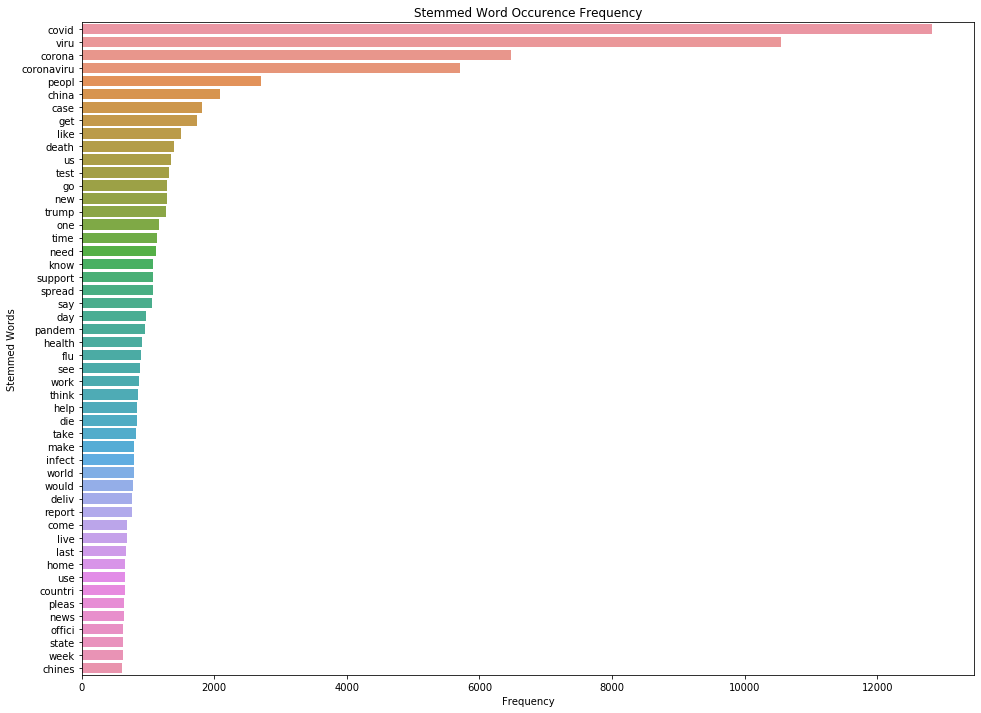

In [52]:
fig, ax = plt.subplots(figsize = (16, 12))
ax = sns.barplot(y="stemmed_word", x='frequency', 
                 ax = ax, data=occurence_df
                    ).set(title = "Stemmed Word Occurence Frequency", xlabel = 'Frequency', ylabel = 'Stemmed Words' )

## Plotting the Word Cloud

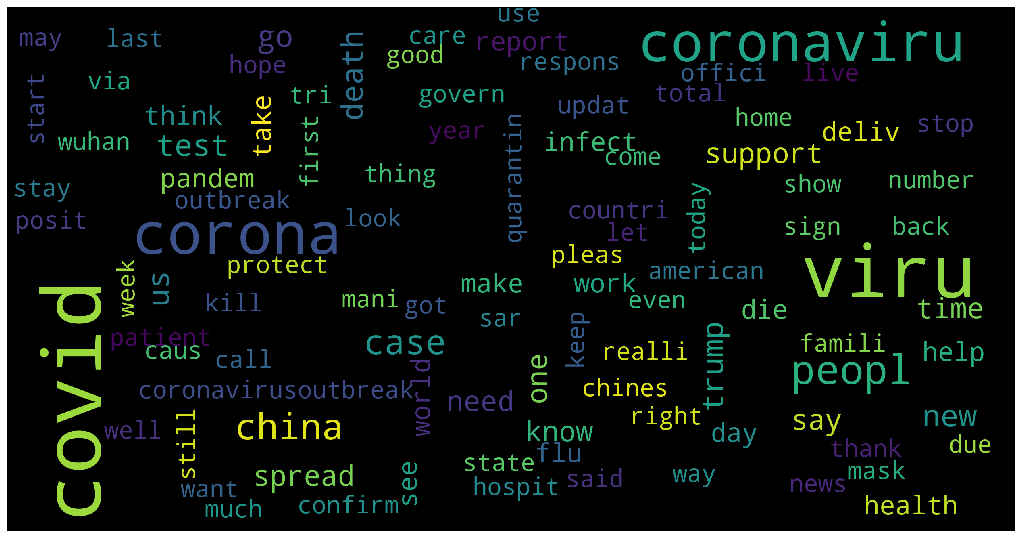

In [56]:
wordcloud = WordCloud(
    max_words=100,
    width=500,
    height=260,
    max_font_size=40, 
    scale=5,
    random_state=2,
    collocations=False,
    normalize_plurals=False
)

wordcloud.generate(' '.join(word_to_list))


plt.figure(figsize = (14, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Running Sentiment Analysis

In [57]:
#polarity score for each tweet
sia_object = SentimentIntensityAnalyzer()
polarity_scores = english_tweets['prep_text'].apply(lambda x: sia_object.polarity_scores(x))

polarity_scores_df = pd.DataFrame(list(polarity_scores))
polarity_scores_df.head()

,neg,neu,pos,compound
0,0.000,0.873,0.127,0.3245
1,0.000,0.766,0.234,0.5994
2,0.401,0.599,0.000,-0.7717
3,0.215,0.785,0.000,-0.6369
4,0.248,0.437,0.316,0.3400


## Categorizing sentiments as positive, negative or neutral

In [58]:
polarity_scores_df['sentiment'] = polarity_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
polarity_scores_df.head()


,neg,neu,pos,compound,sentiment
0,0.000,0.873,0.127,0.3245,positive
1,0.000,0.766,0.234,0.5994,positive
2,0.401,0.599,0.000,-0.7717,negative
3,0.215,0.785,0.000,-0.6369,negative
4,0.248,0.437,0.316,0.3400,positive


In [59]:
sentiment_counts = pd.DataFrame.from_dict(Counter(polarity_scores_df['sentiment']), orient = 'index').reset_index()
sentiment_counts.columns = ['sentiment', 'frequency']
sentiment_counts

,sentiment,frequency
0,positive,7612
1,negative,7720
2,neutral,4914


## Plotting sentiment frequency

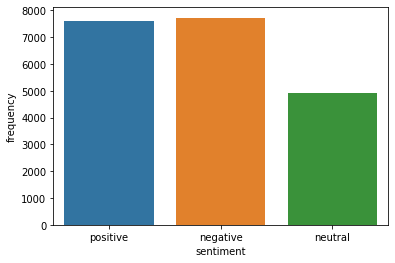

In [60]:
sns.barplot(y="frequency", x='sentiment', data=sentiment_counts).set
plt.show()